#...NEURAL NETWORK FROM SCRATCH...

installing the basic libraries and dataset

In [2]:

 !pip install nnfs
import numpy as np
import nnfs #using to get Spiral DATA
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

nnfs.init()

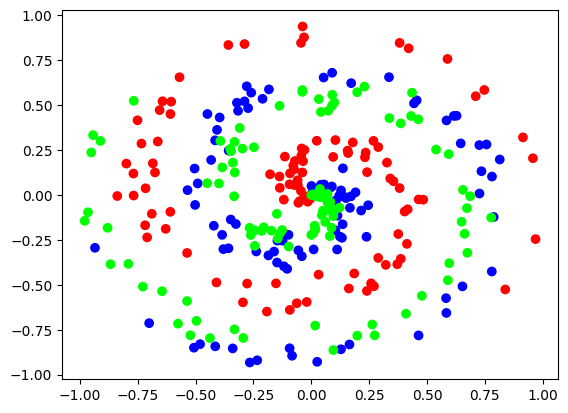

In [3]:
x,y= spiral_data(samples=100, classes=3)
plt.scatter(x[:,0,],x[:,1],c=y, cmap='brg')
plt.show()

Dense Layer...

In [4]:
class Dense_Layer:
  def __init__(self,n_inputs,n_neurons):
    #randomly initializing weights by Gaussian distribution
    self.weights= 0.01 * np.random.randn(n_inputs,n_neurons)
    self.biases= np.zeros((1,n_neurons))

  #FORWARD_PASS
  def forward(self,inputs):
    self.inputs = inputs
    #computing the Dot product...
    self.output = np.dot(inputs,self.weights) + self.biases

  #BACKWARD_PASS
  def backward(self,dvalues):
    self.dweights = np.dot(self.inputs.T,dvalues)#Gradient for weights, Bias and inputs...
    self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
    self.dinputs = np.dot(dvalues,self.weights.T)


Activation Functionss...

In [5]:
class activation_relu:
  def forward(self,inputs):
    self.inputs = inputs #forward pass

    self.output = np.maximum(0,inputs)#-->applying relu property..

  def backward(self,dvalues):
    self.dinputs = dvalues.copy()
    self.dinputs[self.inputs <= 0] = 0 #-> Zero gradient for Negative values

class activation_softmax:
  #forward
  def forward(self,inputs):
    exp_values = np.exp(inputs - np.max(inputs,axis=1,keepdims=True))
    probabilities = exp_values / np.sum(exp_values,axis=1,keepdims=True)
    self.output = probabilities



Loss Function...

In [6]:
class Loss:
  def calculate(self,output,y):
    sample_losses = self.forward(output,y)
    data_loss = np.mean(sample_losses)
    return data_loss

In [7]:
class categorical_cross_entropy(Loss):
  #forward
  def forward(self,y_pred,y_true):
    samples =len(y_pred)
    y_pred_clipped = np.clip(y_pred,1e-7,1-1e-7)#--> to prevent divsion by 0
    #only if categorical labels are given
    if len(y_true.shape) == 1:
      correct_confidences = y_pred_clipped[range(samples),y_true]
    #for one-hot encoded
    elif len(y_true.shape) == 2:
      correct_confidences = np.sum(y_pred_clipped*y_true,axis=1)

    #Losses calculation
    negative_log_likelihoods = -np.log(correct_confidences)
    return negative_log_likelihoods

  #backward pass
  def backward(self,dvalues,y_true):
    samples = len(dvalues)
    labels = len(dvalues[0])

    if len(y_true.shape) == 1:
      y_true = np.eye(labels)[y_true]

    self.dinputs = -y_true / dvalues
    self.dinputs = self.dinputs / samples

Combined(softmax+cross_entropy_loss)

In [8]:
class activation_softmax_loss_categorical_crossentropy():
  def __init__(self):
    self.activation = activation_softmax()
    self.loss = categorical_cross_entropy()

  def forward(self,inputs,y_true):
    self.activation.forward(inputs)
    self.output = self.activation.output
    return self.loss.calculate(self.output,y_true)

  def backward(self,dvalues,y_true):
    samples = len(dvalues)
    if len(y_true.shape) == 2:
      y_true = np.argmax(y_true,axis=1)

    self.dinputs = dvalues.copy()
    self.dinputs[range(samples),y_true] -= 1
    self.dinputs = self.dinputs / samples


Optimizer

In [12]:
class optimizer_adam:
  def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon
    self.beta_1 = beta_1
    self.beta_2 = beta_2

  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

  def update_parameters(self, layer):
    if not hasattr(layer, 'weight_cache'):
      layer.weight_momentums = np.zeros_like(layer.weights)
      layer.weight_cache = np.zeros_like(layer.weights)
      layer.bias_momentums = np.zeros_like(layer.biases)
      layer.bias_cache = np.zeros_like(layer.biases)

    layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
    layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

    weight_momentums_corrected = layer.weight_momentums/ (1 - self.beta_1 ** (self.iterations + 1))
    bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

    layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
    layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

    weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
    bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

    # Update weights and biases
    layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
    layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

  def post_update_params(self):
    self.iterations += 1

Traing

In [13]:
#Dataset creation
x,y = spiral_data(samples=100, classes=3)

dense1 = Dense_Layer(2,64)#--> with 2 I/P features x,y cordinates and 64 O/P
activation1 = activation_relu()

dense2 = Dense_Layer(64,3)#-->takes 64 I/P features & 3 O/P
loss_activation = activation_softmax_loss_categorical_crossentropy()

#optimiser
optimizer = optimizer_adam(learning_rate=0.02, decay=1e-5)

#Training in loop
for epoch in range(10001):
  dense1.forward(x)
  activation1.forward(dense1.output)#-->giving dense1 output as input to activation

  dense2.forward(activation1.output)

  loss = loss_activation.forward(dense2.output,y)

  #accuracy
  predictions = np.argmax(loss_activation.output,axis=1)
  if len(y.shape) == 2:
    y = np.argmax(y,axis=1)
  accuracy = np.mean(predictions==y)

  if not epoch % 100:
    print(f'epoch: {epoch}, ' +
          f'acc: {accuracy:.3f}, ' +
          f'loss: {loss:.3f}, ' +
          f'lr: {optimizer.current_learning_rate}')

  #backward pass
  loss_activation.backward(loss_activation.output,y)
  dense2.backward(loss_activation.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)

  #weights and biases updation step
  optimizer.pre_update_params()
  optimizer.update_parameters(dense1)
  optimizer.update_parameters(dense2)
  optimizer.post_update_params()

epoch: 0, acc: 0.390, loss: 1.099, lr: 0.02
epoch: 100, acc: 0.560, loss: 0.861, lr: 0.01998021958261321
epoch: 200, acc: 0.637, loss: 0.757, lr: 0.019960279044701046
epoch: 300, acc: 0.640, loss: 0.689, lr: 0.019940378268975763
epoch: 400, acc: 0.710, loss: 0.617, lr: 0.01992051713662487
epoch: 500, acc: 0.760, loss: 0.552, lr: 0.01990069552930875
epoch: 600, acc: 0.787, loss: 0.485, lr: 0.019880913329158343
epoch: 700, acc: 0.813, loss: 0.424, lr: 0.019861170418772778
epoch: 800, acc: 0.827, loss: 0.374, lr: 0.019841466681217078
epoch: 900, acc: 0.873, loss: 0.342, lr: 0.01982180200001982
epoch: 1000, acc: 0.887, loss: 0.321, lr: 0.019802176259170884
epoch: 1100, acc: 0.880, loss: 0.305, lr: 0.01978258934311912
epoch: 1200, acc: 0.883, loss: 0.291, lr: 0.01976304113677013
epoch: 1300, acc: 0.887, loss: 0.275, lr: 0.019743531525483964
epoch: 1400, acc: 0.890, loss: 0.265, lr: 0.01972406039507293
epoch: 1500, acc: 0.887, loss: 0.257, lr: 0.019704627631799327
epoch: 1600, acc: 0.893, lo

Test Loss: 1.001, Test Accuracy: 0.780


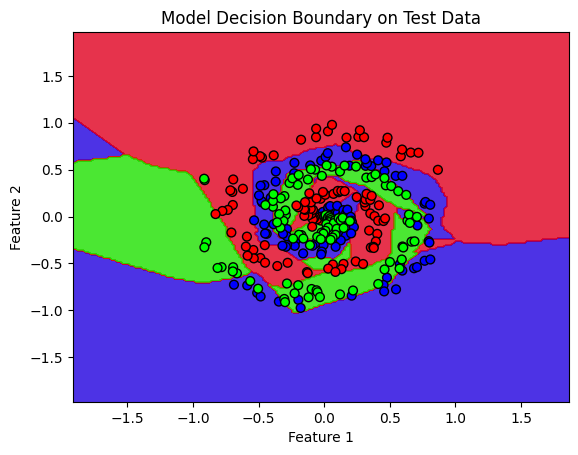

In [16]:
# Generate test data
X_test, y_test = spiral_data(samples=100, classes=3)

# Perform a forward pass on test data
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)

# Calculate loss and accuracy on test data
test_loss = loss_activation.forward(dense2.output, y_test)
test_predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test
test_accuracy = np.mean(test_predictions == y_test_labels)

print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')

# Visualize the decision boundary

# Define model boundaries for plotting
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1

# Generate a meshgrid of points
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Flatten the meshgrid points for model input
meshgrid_input = np.c_[xx.ravel(), yy.ravel()]

# Perform a forward pass on the meshgrid points
dense1.forward(meshgrid_input)
activation1.forward(dense1.output)
dense2.forward(activation1.output)

# Get predictions (class probabilities) for the meshgrid points
# Instead of loss_activation.forward, call the activation directly:
loss_activation.activation.forward(dense2.output)
Z = np.argmax(loss_activation.activation.output, axis=1)

# Reshape the predictions to match the meshgrid for contour plotting
Z = Z.reshape(xx.shape)

# Plot the contourf (decision regions)
plt.contourf(xx, yy, Z, cmap='brg', alpha=0.8)

# Plot the test data points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_labels, s=40, cmap='brg', edgecolors='k')

plt.title('Model Decision Boundary on Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()